In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Tue Aug  8 17:32:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   63C    P0   288W / 300W |  34063MiB / 80994MiB |    100%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Hyperparams

In [3]:
n_mels = 80
n_outputs = 61
n_frames = 400

In [29]:
from model.model_glowtts import Model
from utils.util import *

device = 'cuda:0'

# Model
model = Model(in_dim=80, enc_hidden_dim=256, out_dim=61, dec_hidden_dim=256)
model = model.to(device)
model.eval()
print('done')

done


In [7]:
!ls -lt /data/scpark/save/lips/train08.07-1/

total 32969588
-rw-rw-r-- 1 scpark scpark      2119  8월  8 17:32 events.out.tfevents.1691481261.GPUSVR11
-rw-rw-r-- 1 scpark scpark         0  8월  8 16:54 events.out.tfevents.1691481248.GPUSVR11
-rw-rw-r-- 1 scpark scpark     55837  8월  8 16:53 events.out.tfevents.1691420013.GPUSVR11
-rw-rw-r-- 1 scpark scpark 582076639  8월  8 16:42 save_56000
-rw-rw-r-- 1 scpark scpark 582076639  8월  8 16:24 save_55000
-rw-rw-r-- 1 scpark scpark 582076639  8월  8 16:07 save_54000
-rw-rw-r-- 1 scpark scpark 582076639  8월  8 15:49 save_53000
-rw-rw-r-- 1 scpark scpark 582076639  8월  8 15:30 save_52000
-rw-rw-r-- 1 scpark scpark 582076639  8월  8 15:12 save_51000
-rw-rw-r-- 1 scpark scpark 582076639  8월  8 14:54 save_50000
-rw-rw-r-- 1 scpark scpark 582076639  8월  8 14:36 save_49000
-rw-rw-r-- 1 scpark scpark 582076639  8월  8 14:18 save_48000
-rw-rw-r-- 1 scpark scpark 582076639  8월  8 14:01 save_47000
-rw-rw-r-- 1 scpark scpark 582076639  8월  8 13:44 save_46000
-rw-rw-r-- 1 scpark scpark 582076639  8월  8 

In [32]:
path = '/data/scpark/save/lips/train08.07-1/save_56000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))    
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('done')

done


In [21]:
!ls -lS /Storage/speech/tts/kaist-audio-book/wav/남1_동화1/

total 732912
-rw-r--r-- 1 guhyun guhyun 1277038  5월 11 19:49 141.spec.pt
-rwxrwxrwx 1 scpark scpark 1199818 11월 13  2019 1181.wav
-rwxrwxrwx 1 scpark scpark 1158070 11월 13  2019 1449.wav
-rw-r--r-- 1 guhyun guhyun 1086254  5월 11 19:49 232.spec.pt
-rw-r--r-- 1 guhyun guhyun 1065710  5월 11 19:49 231.spec.pt
-rw-r--r-- 1 guhyun guhyun  983598  5월 11 19:48 763.spec.pt
-rw-r--r-- 1 guhyun guhyun  971310  5월 11 19:49 140.spec.pt
-rw-r--r-- 1 guhyun guhyun  954929  5월 11 19:48 1801.spec.pt
-rw-r--r-- 1 guhyun guhyun  944625  5월 11 19:48 1512.spec.pt
-rw-r--r-- 1 guhyun guhyun  944625  5월 11 19:33 1805.spec.pt
-rw-r--r-- 1 guhyun guhyun  928238  5월 11 19:48 868.spec.pt
-rw-r--r-- 1 guhyun guhyun  920049  5월 11 19:48 1433.spec.pt
-rw-r--r-- 1 guhyun guhyun  920049  5월 11 19:48 2007.spec.pt
-rw-r--r-- 1 guhyun guhyun  917937  5월 11 19:33 1036.spec.pt
-rw-r--r-- 1 guhyun guhyun  917934  5월 11 19:33 257.spec.pt
-rw-r--r-- 1 guhyun guhyun  913841  5월 11 19:48 1098.spec.pt
-rwxrwxrwx 1 scpark scpark

In [33]:
from torchaudio.transforms import MelSpectrogram
melfunc = MelSpectrogram(sample_rate=24000, n_fft=2048, hop_length=800, n_mels=80, window_fn=torch.hann_window)
wav_file = '/Storage/speech/tts/kaist-audio-book/wav/남1_동화1/1181.wav'
wav, _ = librosa.load(wav_file, sr=24000, res_type='polyphase')
mel = melfunc(torch.Tensor(wav).unsqueeze(0)).to(device)
mel = torch.log10(mel + 1e-5) / 1e-5
print(mel.shape)

torch.Size([1, 80, 399])


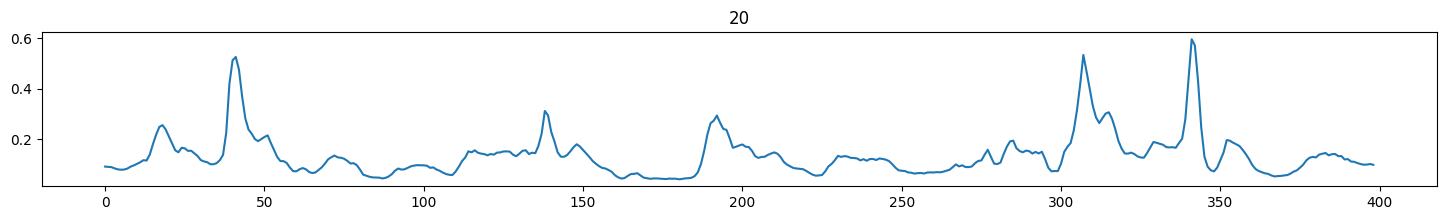

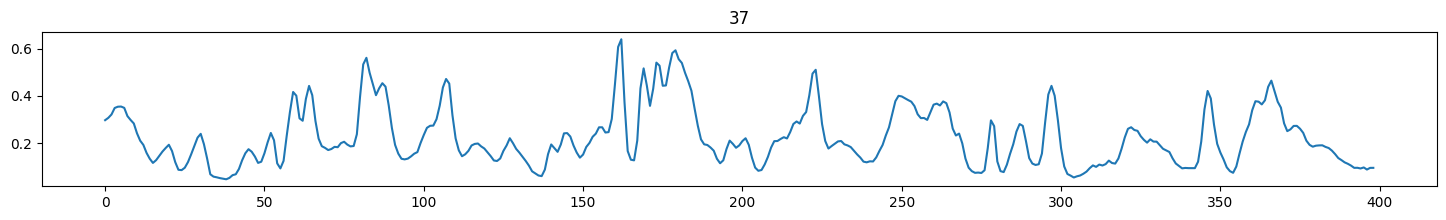

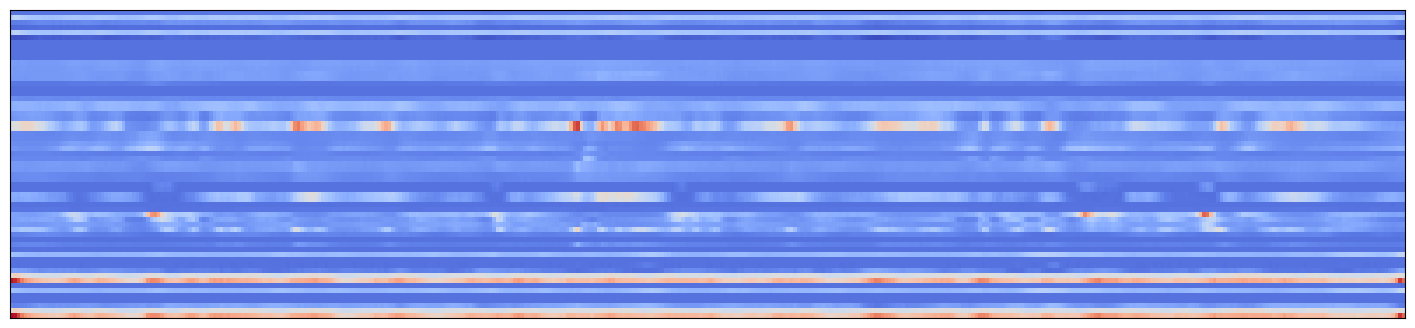

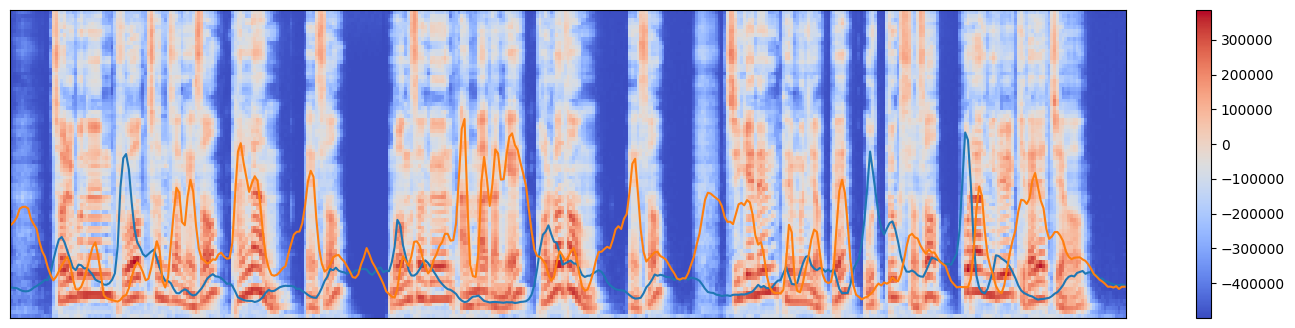

In [41]:
import matplotlib.pyplot as plt
import librosa.display

with torch.no_grad():
    y = model.inference(mel, temperature=0.1)
    
for i in [20, 37]:
    plt.figure(figsize=[18, 2])
    plt.title(str(i))
    plt.plot(y[0].data.cpu().numpy()[i])
    plt.show()

plt.figure(figsize=[18, 4])
librosa.display.specshow(y[0].data.cpu().numpy())
plt.show()

plt.figure(figsize=[18, 4])
librosa.display.specshow(mel[0].data.cpu().numpy())
for i in [20, 37]:
    plt.plot(y[0].data.cpu().numpy()[i] * 80)

plt.colorbar()
plt.show()